# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [3]:
class Point:
    def __init__(self, x , y):
        self.x = x
        self.y = y
    
    def toTuple(self):
        return self.x, self.y
    def __str__(self):
        return f"{[self.x,self.y]}"
    def __repr__(self):
        return f"{[self.x,self.y]}"
    def __eq__(self, other):
        if isinstance(other, Point):
            return self.x == other.x and self.y==other.y
        return False


In [4]:
class Line:
    def __init__(self, a , b):
        self.a = a
        self.b = b
    
    def toTuple(self):
        return self.a, self.b
    def __str__(self):
        return f"{[self.a,self.b]}"
    def __repr__(self):
        return f"{[self.a,self.b]}"


In [5]:
class Triangle:
    def __init__(self,a,b,c):
        self.a=a
        self.b=b
        self.c=c
    def toTuple(self):
        return self.a, self.b,self.c
    
    def __str__(self):
        return f"{[self.a,self.b,self.c]}"
    def __eq__(self, other):
        if isinstance(other, Triangle):
            return self.a == other.a and self.b==other.b and self.c==other.c
        return False
#    def toLines(self):
#        lines=[]
#        lines.append(Line(self.a,self.b))
#        lines.append(Line(self.b,self.c))
#        lines.append(Line(self.c,self.a))
#        return(lines)
        

In [6]:
import json as js
def importPoints(filename):
    loadedPoints=[]
    loadedTriangles=[]
    
    with open(filename, 'r') as file:
        json = file.read()
    for points in js.loads(json)["points"]:
        for point in points:
            loadedPoints.append(Point(point[0],point[1]))
    for triangles in js.loads(json)["triangles"]:
        for triangle in triangles:
            loadedTriangles.append(Triangle(triangle[0],triangle[1],triangle[2]))
    
    return loadedPoints, loadedTriangles

In [7]:
def exportPoints(filename,points,triangles):
    
    toWrite=js.dumps({"points": [[point.toTuple() for point in points]],
                      "triangles": [[triangle.toTuple() for triangle in triangles]]})
    with open(filename, 'w') as file:
        json = file.write(toWrite)
    
    return True

In [8]:
import random

def generatePoints(x1,y1,x2,y2,n):
    points=[]
    for x in range(n):
         points.append(Point(random.uniform(x1,x2),random.uniform(y1,y2)))
    return points


In [9]:
def trianglesToLines(triangles,points):
    lines=[]
    for t in triangles:
        a=points[t.a].toTuple()
        b=points[t.b].toTuple()
        c=points[t.c].toTuple()
        lines.append((a,b))
        lines.append((b,c))
        lines.append((c,a))
        
    return lines
    

<IPython.core.display.Javascript object>


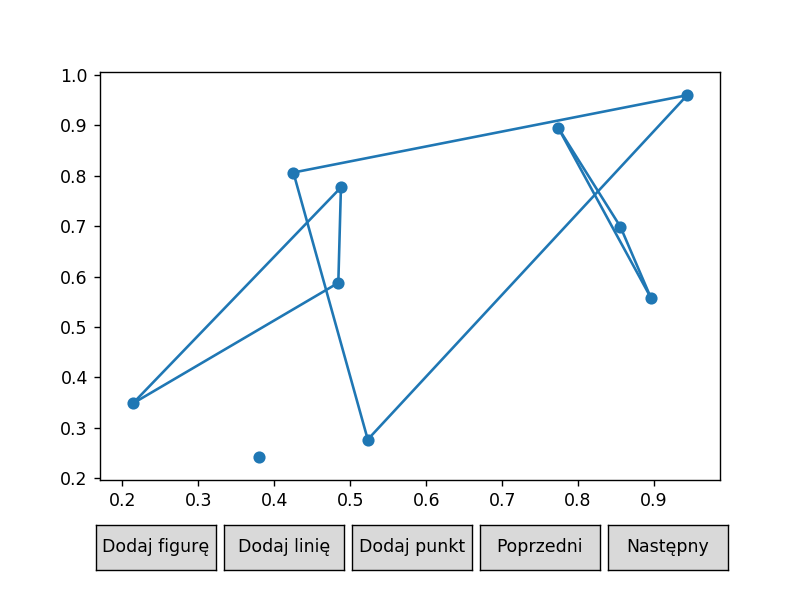

In [10]:
%matplotlib notebook
points=generatePoints(0,0,1,1,10)
triangles=[]
triangles.append(Triangle(1,2,3))
triangles.append(Triangle(4,5,6))
triangles.append(Triangle(7,8,9))
lines=trianglesToLines(triangles,points)

#print(lines)
scenes=[Scene([PointsCollection([point.toTuple() for point in points])],
              lines=[LinesCollection( lines)])]

plot=Plot(scenes)
plot.draw() 

In [11]:
exportPoints("punkty.txt",points,triangles)

True

In [12]:
points,triangles=importPoints("siatka.txt")
for p in points:
    print (p)
for t in triangles:
    print (t)

[1, 4]
[2, 2]
[2, 7]
[2, 10]
[4, 5]
[5, 9]
[6, 3]
[7, 7]
[8, 5]
[9, 2]
[0, 1, 4]
[0, 2, 4]
[2, 3, 5]
[2, 4, 5]
[4, 5, 7]
[1, 4, 6]
[4, 6, 7]
[6, 7, 8]
[6, 8, 9]


<IPython.core.display.Javascript object>


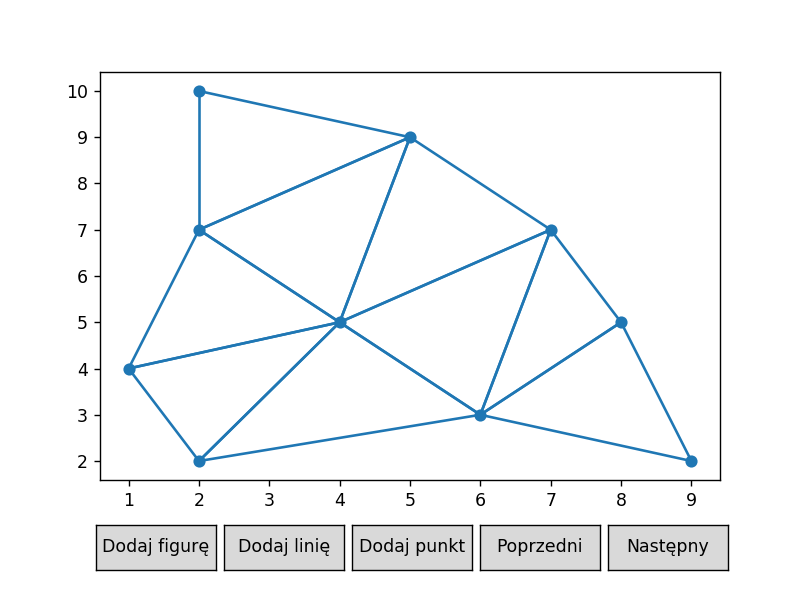

In [13]:
points,triangles=importPoints("siatka.txt")
scenes=[Scene([PointsCollection([point.toTuple() for point in points])],
              lines=[LinesCollection(trianglesToLines(triangles,points))])]

plot=Plot(scenes)
plot.draw() 

# Winged edge data structure

In [46]:
class EdgeW: 
    def __init__(self,vOrg,vDest,fl,fr,elcw,elcww,ercw,ercww):
        self.vertexOrigin=vOrg
        self.vertexDestination=vDest
        self.faceLeft=fl
        self.faceRight=fr
        self.edgeLeftCw=elcw
        self.edgeLeftCww=elcww
        self.edgeRighCw=ercw
        self.edgeRightCww=ercww
    def __repr__(self):
        return f"{[self.vertexOrigin,self.vertexDestination]}"
#,self.faceLeft,self.faceRight,self.edgeLeftCw,self.edgeLeftCww,self.edgeRightCw,self.edgeRightCww]}"
    
class VertexW:
    def __init__(self,x,y,edge): 
        self.x=x
        self.y=y
        self.edge=edge
    def __eq__(self, other):
        if isinstance(other, VertexW):
            return self.x == other.x and self.y==other.y
        return False
    def __repr__(self):
        return f"{[self.x,self.y]}"
class FaceW: 
    def __init__(self,edge):
        self.edge=edge
    def __repr__(self):
        return f"{[self.edge]}"

In [47]:
a=VertexW(1,1,12)
b=VertexW(1,1,13)
a==b


True

In [48]:
def findCommonEdge(t1,t2):
    commonPoints=[]
    for p1 in t1.toTuple():
        for p2 in t2.toTuple():
            if(p1==p2):
                commonPoints.append(p1)
    if(len(commonPoints)==2):
        return True,commonPoints[0],commonPoints[1]
    else:
        return False,None,None

In [49]:
def findEdgesAdjacentToEdge(t1,t2,sp,ep):
    for p in t1:
        if(p!=sp and p!=ep):
            lp=p
    for p in t2:
        if(p!=sp and p!=ep):
            rp=p
    return lp,rp

In [57]:
def fromTrianglesToWingedEdge(points,triangles):
    edges=[]
    vertexes=[]
    vi=0
    faces=[]
    fi=0
    
    for point in points:
        vertexes.append(VertexW(point.x,point.y,None))
    for triangle in triangles:
        pointA=vertexes[triangle.a]
        pointB=vertexes[triangle.b]
        pointC=vertexes[triangle.c]
        edges.append(EdgeW(pointA,pointB,None,None,None,None,None,None))
        faces.append(FaceW(edges[-1]))
        edges.append(EdgeW(pointB,pointC,None,None,None,None,None,None))
        edges.append(EdgeW(pointC,pointA,None,None,None,None,None,None))
    for edge in edges:
        for vertex in vertexes:
            if (vertex==edge.vertexOrigin):
                vertex.edge=edge
    for edge in edges:
        for vertex in vertexes:
            if (vertex==edge.vertexOrigin):
                vertex.edge=edge
    for vertex in vertexes:
        print (vertex)
    for face in faces:
        print (face)
    for edge in edges:
        print (edge)
    
    
            


In [58]:
fromTrianglesToWingedEdge (points,triangles)

[1, 4]
[2, 2]
[2, 7]
[2, 10]
[4, 5]
[5, 9]
[6, 3]
[7, 7]
[8, 5]
[9, 2]
[[[1, 4], [2, 2]]]
[[[1, 4], [2, 7]]]
[[[2, 7], [2, 10]]]
[[[2, 7], [4, 5]]]
[[[4, 5], [5, 9]]]
[[[2, 2], [4, 5]]]
[[[4, 5], [6, 3]]]
[[[6, 3], [7, 7]]]
[[[6, 3], [8, 5]]]
[[1, 4], [2, 2]]
[[2, 2], [4, 5]]
[[4, 5], [1, 4]]
[[1, 4], [2, 7]]
[[2, 7], [4, 5]]
[[4, 5], [1, 4]]
[[2, 7], [2, 10]]
[[2, 10], [5, 9]]
[[5, 9], [2, 7]]
[[2, 7], [4, 5]]
[[4, 5], [5, 9]]
[[5, 9], [2, 7]]
[[4, 5], [5, 9]]
[[5, 9], [7, 7]]
[[7, 7], [4, 5]]
[[2, 2], [4, 5]]
[[4, 5], [6, 3]]
[[6, 3], [2, 2]]
[[4, 5], [6, 3]]
[[6, 3], [7, 7]]
[[7, 7], [4, 5]]
[[6, 3], [7, 7]]
[[7, 7], [8, 5]]
[[8, 5], [6, 3]]
[[6, 3], [8, 5]]
[[8, 5], [9, 2]]
[[9, 2], [6, 3]]


<IPython.core.display.Javascript object>


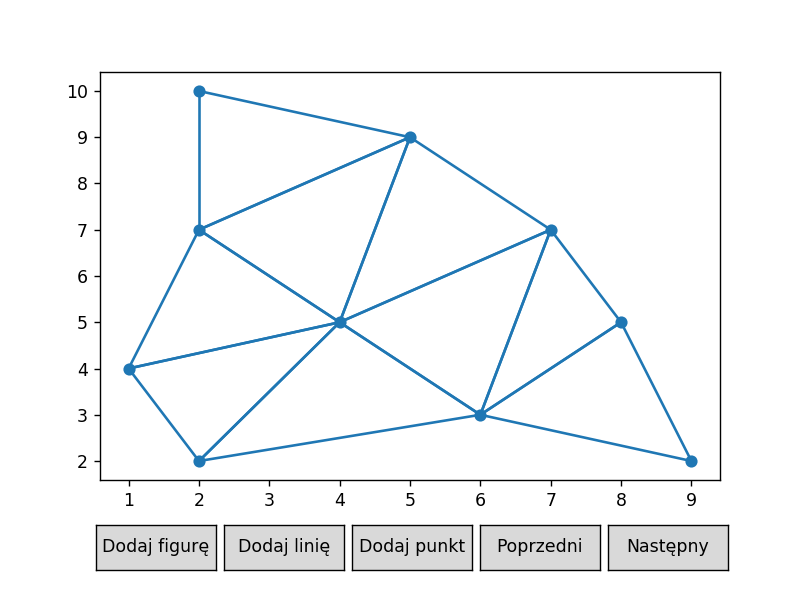

In [56]:
points,triangles=importPoints("siatka.txt")
scenes=[Scene([PointsCollection([point.toTuple() for point in points])],
              lines=[LinesCollection(trianglesToLines(triangles,points))])]

plot=Plot(scenes)
plot.draw() 

In [ ]:
class Line:
    def __init__(self, a , b):
        self.a = a
        self.b = b
    
    def toTuple(self):
        return self.a, self.b
    def __str__(self):
        return f"{[self.a,self.b]}"
    def __repr__(self):
        return f"{[self.a,self.b]}"

In [ ]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [ ]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()